In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [184]:
full_medals = pd.read_csv('data/sim_full_medal_data.csv')
full_medals = full_medals.sort_values(by=['Country Code', 'Year']).reset_index(drop=True).dropna()
full_medals

,Unnamed: 0.1,Unnamed: 0,Rank,NOC,Gold,Silver,Bronze,Total,Year,Country Code,Is_Host,Ex-Host,Host Continent,Team Size,Participated Events,Total Events,Total Male Participants,Total Female Participants
0,0,1522,0.0,Afghanistan,0.0,0.0,0.0,0.0,1936,AFG,0,0,0,16.0,4,129.0,15.0,0.0
1,1,1540,0.0,Afghanistan,0.0,0.0,0.0,0.0,1948,AFG,0,0,0,25.0,2,136.0,22.0,0.0
2,2,1584,0.0,Afghanistan,0.0,0.0,0.0,0.0,1956,AFG,0,0,0,12.0,1,151.0,12.0,0.0
3,3,1653,0.0,Afghanistan,0.0,0.0,0.0,0.0,1960,AFG,0,0,0,16.0,13,150.0,12.0,0.0
4,4,1674,0.0,Afghanistan,0.0,0.0,0.0,0.0,1964,AFG,0,0,1,8.0,8,163.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3402,3402,1026,38.0,Zimbabwe,1.0,3.0,0.0,4.0,2008,ZIM,0,0,0,16.0,15,302.0,8.0,5.0
3403,3403,2814,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2012,ZIM,0,0,0,9.0,8,302.0,4.0,3.0
3404,3404,2916,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2016,ZIM,0,0,0,31.0,13,306.0,9.0,21.0
3405,3405,3079,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2020,ZIM,0,0,0,5.0,5,339.0,4.0,1.0


In [185]:
full_medals.loc[:, 'Possible Gold'] = full_medals.groupby('Year')['Gold'].transform('sum')
full_medals.loc[:, 'Possible Silver'] = full_medals.groupby('Year')['Silver'].transform('sum')
full_medals.loc[:, 'Possible Bronze'] = full_medals.groupby('Year')['Bronze'].transform('sum')

full_medals.loc[:, '% Female'] = full_medals.loc[:, 'Total Female Participants'] / (full_medals.loc[:, 'Total Female Participants'] + full_medals.loc[:, 'Total Male Participants'])

full_medals

,Unnamed: 0.1,Unnamed: 0,Rank,NOC,Gold,Silver,Bronze,Total,Year,Country Code,Is_Host,Ex-Host,Host Continent,Team Size,Participated Events,Total Events,Total Male Participants,Total Female Participants,Possible Gold,Possible Silver,Possible Bronze,% Female
0,0,1522,0.0,Afghanistan,0.0,0.0,0.0,0.0,1936,AFG,0,0,0,16.0,4,129.0,15.0,0.0,141.0,140.0,141.0,0.000000
1,1,1540,0.0,Afghanistan,0.0,0.0,0.0,0.0,1948,AFG,0,0,0,25.0,2,136.0,22.0,0.0,138.0,135.0,138.0,0.000000
2,2,1584,0.0,Afghanistan,0.0,0.0,0.0,0.0,1956,AFG,0,0,0,12.0,1,151.0,12.0,0.0,153.0,153.0,163.0,0.000000
3,3,1653,0.0,Afghanistan,0.0,0.0,0.0,0.0,1960,AFG,0,0,0,16.0,13,150.0,12.0,0.0,152.0,149.0,160.0,0.000000
4,4,1674,0.0,Afghanistan,0.0,0.0,0.0,0.0,1964,AFG,0,0,1,8.0,8,163.0,8.0,0.0,163.0,167.0,174.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3402,3402,1026,38.0,Zimbabwe,1.0,3.0,0.0,4.0,2008,ZIM,0,0,0,16.0,15,302.0,8.0,5.0,302.0,303.0,353.0,0.384615
3403,3403,2814,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2012,ZIM,0,0,0,9.0,8,302.0,4.0,3.0,303.0,305.0,352.0,0.428571
3404,3404,2916,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2016,ZIM,0,0,0,31.0,13,306.0,9.0,21.0,306.0,307.0,359.0,0.700000
3405,3405,3079,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2020,ZIM,0,0,0,5.0,5,339.0,4.0,1.0,340.0,338.0,402.0,0.200000


In [186]:
def country_medals(country):
    medals = full_medals.where(full_medals['Country Code'] == country).dropna().sort_values(by="Year")
    return medals

rows = []
countries = full_medals['Country Code'].unique()

n = 3

for i in range(1, n+1):
    full_medals.loc[:, f'Gold - {i}'] = full_medals.groupby('Country Code')['Gold'].shift(periods=i)
    full_medals.loc[:, f'Silver - {i}'] = full_medals.groupby('Country Code')['Silver'].shift(periods=i)
    full_medals.loc[:, f'Bronze - {i}'] = full_medals.groupby('Country Code')['Bronze'].shift(periods=i)

    full_medals.loc[:, f'Team Size - {i}'] = full_medals.groupby('Country Code')['Team Size'].shift(periods=1)    

# full_medals.loc[:, f'Team Size - 1'] = full_medals.groupby('Country Code')['Team Size'].shift(periods=1)

full_medals = full_medals.fillna(0)
full_medals

,Unnamed: 0.1,Unnamed: 0,Rank,NOC,Gold,Silver,Bronze,Total,Year,Country Code,Is_Host,Ex-Host,Host Continent,Team Size,Participated Events,Total Events,Total Male Participants,Total Female Participants,Possible Gold,Possible Silver,Possible Bronze,% Female,Gold - 1,Silver - 1,Bronze - 1,Team Size - 1,Gold - 2,Silver - 2,Bronze - 2,Team Size - 2,Gold - 3,Silver - 3,Bronze - 3,Team Size - 3
0,0,1522,0.0,Afghanistan,0.0,0.0,0.0,0.0,1936,AFG,0,0,0,16.0,4,129.0,15.0,0.0,141.0,140.0,141.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1540,0.0,Afghanistan,0.0,0.0,0.0,0.0,1948,AFG,0,0,0,25.0,2,136.0,22.0,0.0,138.0,135.0,138.0,0.000000,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0
2,2,1584,0.0,Afghanistan,0.0,0.0,0.0,0.0,1956,AFG,0,0,0,12.0,1,151.0,12.0,0.0,153.0,153.0,163.0,0.000000,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0
3,3,1653,0.0,Afghanistan,0.0,0.0,0.0,0.0,1960,AFG,0,0,0,16.0,13,150.0,12.0,0.0,152.0,149.0,160.0,0.000000,0.0,0.0,0.0,12.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,12.0
4,4,1674,0.0,Afghanistan,0.0,0.0,0.0,0.0,1964,AFG,0,0,1,8.0,8,163.0,8.0,0.0,163.0,167.0,174.0,0.000000,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3402,3402,1026,38.0,Zimbabwe,1.0,3.0,0.0,4.0,2008,ZIM,0,0,0,16.0,15,302.0,8.0,5.0,302.0,303.0,353.0,0.384615,1.0,1.0,1.0,14.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,14.0
3403,3403,2814,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2012,ZIM,0,0,0,9.0,8,302.0,4.0,3.0,303.0,305.0,352.0,0.428571,1.0,3.0,0.0,16.0,1.0,1.0,1.0,16.0,0.0,0.0,0.0,16.0
3404,3404,2916,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2016,ZIM,0,0,0,31.0,13,306.0,9.0,21.0,306.0,307.0,359.0,0.700000,0.0,0.0,0.0,9.0,1.0,3.0,0.0,9.0,1.0,1.0,1.0,9.0
3405,3405,3079,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2020,ZIM,0,0,0,5.0,5,339.0,4.0,1.0,340.0,338.0,402.0,0.200000,0.0,0.0,0.0,31.0,0.0,0.0,0.0,31.0,1.0,3.0,0.0,31.0


In [187]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

data = full_medals[['Gold - 1', 'Gold - 2', 'Gold - 3', 'Silver - 1', 'Silver - 2', 'Silver - 3', 'Bronze - 1', 'Bronze - 2', 'Bronze - 3', 'Ex-Host', 'Team Size', 'Participated Events', '% Female', 'Year', 'Possible Gold', 'Possible Silver', 'Possible Bronze', 'Gold', 'Silver', 'Bronze']]

train = data[data['Year'] <= 2012]
test = data[data['Year'] > 2012]

X_train = train.iloc[:, :-7]
y_train = train.iloc[:, -7:]
X_test = test.iloc[:, :-7]
y_test = test.iloc[:, -7:]


truth_counts_train = y_train.iloc[:, :]
y_train = y_train.iloc[:, 4:]
truth_counts_test = y_test.iloc[:, :]
y_test = y_test.iloc[:, 4:]

In [190]:
def scale_predictions(predictions, possible_counts):
    possible_counts = possible_counts.reset_index(drop=True)
    predictions = predictions.reset_index(drop=True)

    possible_counts[['Predicted Gold', 'Predicted Silver', 'Predicted Bronze']] = predictions[['Gold', 'Silver', 'Bronze']]
    possible_counts[['Predicted Upper Gold', 'Predicted Upper Silver', 'Predicted Upper Bronze']] = predictions[['Upper Gold', 'Upper Silver', 'Upper Bronze']]
    possible_counts[['Predicted Lower Gold', 'Predicted Lower Silver', 'Predicted Lower Bronze']] = predictions[['Lower Gold', 'Lower Silver', 'Lower Bronze']]

    gold = ((possible_counts['Predicted Gold'] / possible_counts.groupby('Year')['Predicted Gold'].transform('sum')) * possible_counts['Possible Gold']).astype(int)
    silver = ((possible_counts['Predicted Silver'] / possible_counts.groupby('Year')['Predicted Silver'].transform('sum')) * possible_counts['Possible Silver']).astype(int)
    bronze = ((possible_counts['Predicted Bronze'] / possible_counts.groupby('Year')['Predicted Bronze'].transform('sum')) * possible_counts['Possible Bronze']).astype(int)

    upper_gold = ((possible_counts['Predicted Upper Gold'] / possible_counts.groupby('Year')['Predicted Upper Gold'].transform('sum')) * possible_counts['Possible Gold']).astype(int)
    upper_silver = ((possible_counts['Predicted Upper Silver'] / possible_counts.groupby('Year')['Predicted Upper Silver'].transform('sum')) * possible_counts['Possible Silver']).astype(int)
    upper_bronze = ((possible_counts['Predicted Upper Bronze'] / possible_counts.groupby('Year')['Predicted Upper Bronze'].transform('sum')) * possible_counts['Possible Bronze']).astype(int)

    lower_gold = ((possible_counts['Predicted Lower Gold'] / possible_counts.groupby('Year')['Predicted Lower Gold'].transform('sum')) * possible_counts['Possible Gold']).astype(int)
    lower_silver = ((possible_counts['Predicted Lower Silver'] / possible_counts.groupby('Year')['Predicted Lower Silver'].transform('sum')) * possible_counts['Possible Silver']).astype(int)
    lower_bronze = ((possible_counts['Predicted Lower Bronze'] / possible_counts.groupby('Year')['Predicted Lower Bronze'].transform('sum')) * possible_counts['Possible Bronze']).astype(int)

    return pd.DataFrame({'Gold': gold, 'Silver': silver, 'Bronze': bronze, 'Upper Gold': upper_gold, 'Upper Silver': upper_silver, 'Upper Bronze': upper_bronze, 'Lower Gold': lower_gold, 'Lower Silver': lower_silver, 'Lower Bronze': lower_bronze})


In [46]:
display(y_test.loc[full_medals.loc[y_test.index.values, :].query('NOC == "United States"').index.values, 'Gold'])
y_pred = models[0.5].predict(X_test.loc[full_medals.loc[y_test.index.values, :].query('NOC == "United States"').index.values, :])
y_pred

3271    46.0
3272    39.0
3273    40.0
Name: Gold, dtype: float64

array([35.236595, 48.009052, 38.510933], dtype=float32)

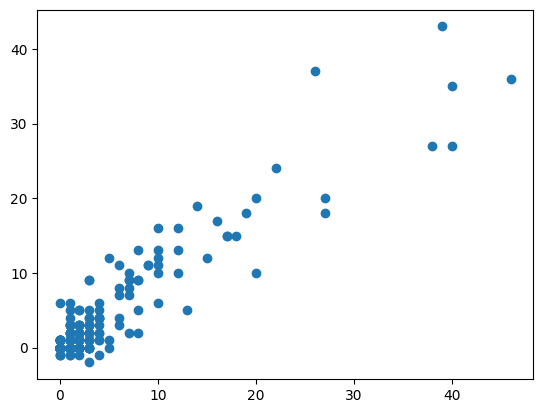

In [10]:
plt.scatter(predictions['Gold'], predictions['Corrected Gold'])

In [191]:
def train_model(X_train, y_train, X_test, n_iterations=100):
    predictions = np.zeros(shape=(n_iterations, len(X_test), len(y_train.columns.values)))
    
    for i in range(n_iterations):
        # Create a bootstrapped dataset
        indices = np.random.choice(len(X_train), len(X_train), replace=True)
        
        X_resampled = X_train.iloc[indices, :]
        y_resampled = y_train.iloc[indices, :]
    
        for j in range(len(y_train.columns.values)):
            # Train an XGBoost model
            model = XGBRegressor()
            model.fit(X_resampled, y_resampled.iloc[:, j])
            
            # Predict on test data
            preds = model.predict(X_test)
            predictions[i,:,j] = preds
    
    
    # # Calculate the mean and standard deviation of the predictions
    mean_preds = np.mean(predictions, axis=0)
    std_preds = np.std(predictions, axis=0)
    
    # # Confidence intervals
    lower_bound = mean_preds - 1.96 * std_preds
    upper_bound = mean_preds + 1.96 * std_preds

    predictions = pd.DataFrame(mean_preds, columns=['Gold', 'Silver', 'Bronze'])
    predictions.loc[:, ['Upper Gold', 'Upper Silver', 'Upper Bronze']] = upper_bound
    predictions.loc[:, ['Lower Gold', 'Lower Silver', 'Lower Bronze']] = lower_bound

    return predictions

In [169]:
predictions = train_model(X_train, y_train, X_test, y_test)

In [172]:
np.set_printoptions(suppress=True)
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test['Gold'], predictions['Gold']))
print(mean_absolute_error(y_test['Silver'], predictions['Silver']))
print(mean_absolute_error(y_test['Bronze'], predictions['Bronze']))

0.6736841230040982
0.7378745783837555
0.7598762255695015


In [173]:
corrected = scale_predictions(predictions, truth_counts_test)

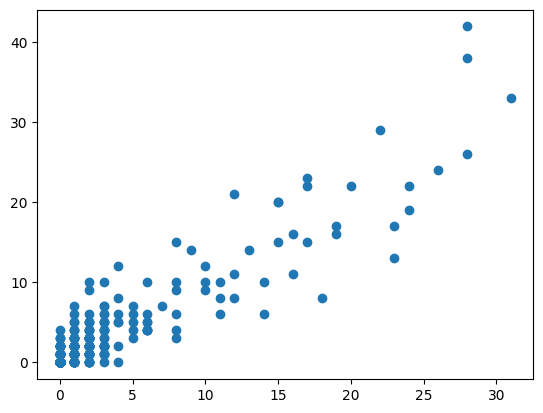

In [174]:
plt.scatter(corrected['Bronze'], y_test['Bronze'])

In [192]:
sim_data = pd.read_csv('data/sim_full_medal_data.csv').sort_values(by=['Country Code', 'Year']).reset_index(drop=True)
sim_data

,Unnamed: 0.1,Unnamed: 0,Rank,NOC,Gold,Silver,Bronze,Total,Year,Country Code,Is_Host,Ex-Host,Host Continent,Team Size,Participated Events,Total Events,Total Male Participants,Total Female Participants
0,0,1522,0.0,Afghanistan,0.0,0.0,0.0,0.0,1936,AFG,0,0,0,16.0,4,129.0,15.0,0.0
1,1,1540,0.0,Afghanistan,0.0,0.0,0.0,0.0,1948,AFG,0,0,0,25.0,2,136.0,22.0,0.0
2,2,1584,0.0,Afghanistan,0.0,0.0,0.0,0.0,1956,AFG,0,0,0,12.0,1,151.0,12.0,0.0
3,3,1653,0.0,Afghanistan,0.0,0.0,0.0,0.0,1960,AFG,0,0,0,16.0,13,150.0,12.0,0.0
4,4,1674,0.0,Afghanistan,0.0,0.0,0.0,0.0,1964,AFG,0,0,1,8.0,8,163.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,3403,2814,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2012,ZIM,0,0,0,9.0,8,302.0,4.0,3.0
3404,3404,2916,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2016,ZIM,0,0,0,31.0,13,306.0,9.0,21.0
3405,3405,3079,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2020,ZIM,0,0,0,5.0,5,339.0,4.0,1.0
3406,3406,3149,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2024,ZIM,0,0,0,7.0,6,329.0,5.0,2.0


In [193]:
sim_data.loc[:, 'Possible Gold'] = sim_data.loc[:, 'Total Events']
sim_data.loc[:, 'Possible Silver'] = sim_data.loc[:, 'Total Events']
sim_data.loc[:, 'Possible Bronze'] = sim_data.loc[:, 'Total Events']
sim_data.loc[:, '% Female'] = sim_data.loc[:, 'Total Female Participants'] / (sim_data.loc[:, 'Total Female Participants'] + sim_data.loc[:, 'Total Male Participants'])
sim_data

,Unnamed: 0.1,Unnamed: 0,Rank,NOC,Gold,Silver,Bronze,Total,Year,Country Code,Is_Host,Ex-Host,Host Continent,Team Size,Participated Events,Total Events,Total Male Participants,Total Female Participants,Possible Gold,Possible Silver,Possible Bronze,% Female
0,0,1522,0.0,Afghanistan,0.0,0.0,0.0,0.0,1936,AFG,0,0,0,16.0,4,129.0,15.0,0.0,129.0,129.0,129.0,0.000000
1,1,1540,0.0,Afghanistan,0.0,0.0,0.0,0.0,1948,AFG,0,0,0,25.0,2,136.0,22.0,0.0,136.0,136.0,136.0,0.000000
2,2,1584,0.0,Afghanistan,0.0,0.0,0.0,0.0,1956,AFG,0,0,0,12.0,1,151.0,12.0,0.0,151.0,151.0,151.0,0.000000
3,3,1653,0.0,Afghanistan,0.0,0.0,0.0,0.0,1960,AFG,0,0,0,16.0,13,150.0,12.0,0.0,150.0,150.0,150.0,0.000000
4,4,1674,0.0,Afghanistan,0.0,0.0,0.0,0.0,1964,AFG,0,0,1,8.0,8,163.0,8.0,0.0,163.0,163.0,163.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,3403,2814,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2012,ZIM,0,0,0,9.0,8,302.0,4.0,3.0,302.0,302.0,302.0,0.428571
3404,3404,2916,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2016,ZIM,0,0,0,31.0,13,306.0,9.0,21.0,306.0,306.0,306.0,0.700000
3405,3405,3079,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2020,ZIM,0,0,0,5.0,5,339.0,4.0,1.0,339.0,339.0,339.0,0.200000
3406,3406,3149,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2024,ZIM,0,0,0,7.0,6,329.0,5.0,2.0,329.0,329.0,329.0,0.285714


In [194]:
n = 3

for i in range(1, n+1):
    sim_data.loc[:, f'Gold - {i}'] = sim_data.groupby('Country Code')['Gold'].shift(periods=i)
    sim_data.loc[:, f'Silver - {i}'] = sim_data.groupby('Country Code')['Silver'].shift(periods=i)
    sim_data.loc[:, f'Bronze - {i}'] = sim_data.groupby('Country Code')['Bronze'].shift(periods=i)

    sim_data.loc[:, f'Team Size - {i}'] = sim_data.groupby('Country Code')['Team Size'].shift(periods=1)    

# full_medals.loc[:, f'Team Size - 1'] = full_medals.groupby('Country Code')['Team Size'].shift(periods=1)

sim_data = sim_data.fillna(0)
sim_data

,Unnamed: 0.1,Unnamed: 0,Rank,NOC,Gold,Silver,Bronze,Total,Year,Country Code,Is_Host,Ex-Host,Host Continent,Team Size,Participated Events,Total Events,Total Male Participants,Total Female Participants,Possible Gold,Possible Silver,Possible Bronze,% Female,Gold - 1,Silver - 1,Bronze - 1,Team Size - 1,Gold - 2,Silver - 2,Bronze - 2,Team Size - 2,Gold - 3,Silver - 3,Bronze - 3,Team Size - 3
0,0,1522,0.0,Afghanistan,0.0,0.0,0.0,0.0,1936,AFG,0,0,0,16.0,4,129.0,15.0,0.0,129.0,129.0,129.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1540,0.0,Afghanistan,0.0,0.0,0.0,0.0,1948,AFG,0,0,0,25.0,2,136.0,22.0,0.0,136.0,136.0,136.0,0.000000,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0
2,2,1584,0.0,Afghanistan,0.0,0.0,0.0,0.0,1956,AFG,0,0,0,12.0,1,151.0,12.0,0.0,151.0,151.0,151.0,0.000000,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0
3,3,1653,0.0,Afghanistan,0.0,0.0,0.0,0.0,1960,AFG,0,0,0,16.0,13,150.0,12.0,0.0,150.0,150.0,150.0,0.000000,0.0,0.0,0.0,12.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,12.0
4,4,1674,0.0,Afghanistan,0.0,0.0,0.0,0.0,1964,AFG,0,0,1,8.0,8,163.0,8.0,0.0,163.0,163.0,163.0,0.000000,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,3403,2814,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2012,ZIM,0,0,0,9.0,8,302.0,4.0,3.0,302.0,302.0,302.0,0.428571,1.0,3.0,0.0,16.0,1.0,1.0,1.0,16.0,0.0,0.0,0.0,16.0
3404,3404,2916,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2016,ZIM,0,0,0,31.0,13,306.0,9.0,21.0,306.0,306.0,306.0,0.700000,0.0,0.0,0.0,9.0,1.0,3.0,0.0,9.0,1.0,1.0,1.0,9.0
3405,3405,3079,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2020,ZIM,0,0,0,5.0,5,339.0,4.0,1.0,339.0,339.0,339.0,0.200000,0.0,0.0,0.0,31.0,0.0,0.0,0.0,31.0,1.0,3.0,0.0,31.0
3406,3406,3149,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2024,ZIM,0,0,0,7.0,6,329.0,5.0,2.0,329.0,329.0,329.0,0.285714,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0


In [225]:
data = sim_data[['Gold - 1', 'Gold - 2', 'Gold - 3', 'Silver - 1', 'Silver - 2', 'Silver - 3', 'Bronze - 1', 'Bronze - 2', 'Bronze - 3', 'Ex-Host', 'Team Size', 'Participated Events', '% Female', 'Year', 'Possible Gold', 'Possible Silver', 'Possible Bronze', 'Gold', 'Silver', 'Bronze']]

train = data[data['Year'] <= 2024]
test = data[data['Year'] >= 2028]


X_train = train.iloc[:, :-7]
y_train = train.iloc[:, -7:]
y_train = y_train.iloc[:, 4:]

X_test = test.iloc[:, :-7]

predictions = train_model(X_train, y_train, X_test, n_iterations=100)

test.loc[:, ['Predicted Gold', 'Predicted Silver', 'Predicted Bronze']] = predictions.loc[:, ['Gold', 'Silver', 'Bronze']].values
test.loc[:, ['Predicted Upper Gold', 'Predicted Upper Silver', 'Predicted Upper Bronze']] = predictions.loc[:, ['Upper Gold', 'Upper Silver', 'Upper Bronze']].values
test.loc[:, ['Predicted Lower Gold', 'Predicted Lower Silver', 'Predicted Lower Bronze']] = predictions.loc[:, ['Lower Gold', 'Lower Silver', 'Lower Bronze']].values

display(test[test.isna().any(axis=1)])

test.loc[:, 'Gold'] = ((test['Predicted Gold'] / test.groupby('Year')['Predicted Gold'].transform('sum')) * test['Possible Gold']).astype(int)
test.loc[:, 'Silver'] = ((test['Predicted Silver'] / test.groupby('Year')['Predicted Silver'].transform('sum')) * test['Possible Silver']).astype(int)
test.loc[:, 'Bronze'] = ((test['Predicted Bronze'] / test.groupby('Year')['Predicted Bronze'].transform('sum')) * test['Possible Bronze']).astype(int)

test.loc[:, 'Upper Gold'] = ((test['Predicted Upper Gold'] / test.groupby('Year')['Predicted Upper Gold'].transform('sum')) * test['Possible Gold']).astype(int)
test.loc[:, 'Upper Silver'] = ((test['Predicted Upper Silver'] / test.groupby('Year')['Predicted Upper Silver'].transform('sum')) * test['Possible Silver']).astype(int)
test.loc[:, 'Upper Bronze'] = ((test['Predicted Upper Bronze'] / test.groupby('Year')['Predicted Upper Bronze'].transform('sum')) * test['Possible Bronze']).astype(int)

test.loc[:, 'Lower Gold'] = ((test['Predicted Lower Gold'] / test.groupby('Year')['Predicted Lower Gold'].transform('sum')) * test['Possible Gold']).astype(int)
test.loc[:, 'Lower Silver'] = ((test['Predicted Lower Silver'] / test.groupby('Year')['Predicted Lower Silver'].transform('sum')) * test['Possible Silver']).astype(int)
test.loc[:, 'Lower Bronze'] = ((test['Predicted Lower Bronze'] / test.groupby('Year')['Predicted Lower Bronze'].transform('sum')) * test['Possible Bronze']).astype(int)

test.loc[:, 'Total'] = test[['Gold', 'Silver', 'Bronze']].sum(axis=1)
test.loc[:, 'Rank'] = test['Total'].rank(ascending = False)

test


,Gold - 1,Gold - 2,Gold - 3,Silver - 1,Silver - 2,Silver - 3,Bronze - 1,Bronze - 2,Bronze - 3,Ex-Host,Team Size,Participated Events,% Female,Year,Possible Gold,Possible Silver,Possible Bronze,Gold,Silver,Bronze,Predicted Gold,Predicted Silver,Predicted Bronze,Predicted Upper Gold,Predicted Upper Silver,Predicted Upper Bronze,Predicted Lower Gold,Predicted Lower Silver,Predicted Lower Bronze


/var/folders/5c/216t7l5x1_j3zsn2fm8z7s180000gn/T/ipykernel_79302/1158524632.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'Upper Gold'] = ((test['Predicted Upper Gold'] / test.groupby('Year')['Predicted Upper Gold'].transform('sum')) * test['Possible Gold']).astype(int)
/var/folders/5c/216t7l5x1_j3zsn2fm8z7s180000gn/T/ipykernel_79302/1158524632.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'Upper Silver'] = ((test['Predicted Upper Silver'] / test.groupby('Year')['Predic

,Gold - 1,Gold - 2,Gold - 3,Silver - 1,Silver - 2,Silver - 3,Bronze - 1,Bronze - 2,Bronze - 3,Ex-Host,Team Size,Participated Events,% Female,Year,Possible Gold,Possible Silver,Possible Bronze,Gold,Silver,Bronze,Predicted Gold,Predicted Silver,Predicted Bronze,Predicted Upper Gold,Predicted Upper Silver,Predicted Upper Bronze,Predicted Lower Gold,Predicted Lower Silver,Predicted Lower Bronze,Upper Gold,Upper Silver,Upper Bronze,Lower Gold,Lower Silver,Lower Bronze,Total,Rank
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,6.0,5,0.400000,2028,334.0,334.0,334.0,0.0,0.0,0.0,0.009511,0.001255,0.004197,0.032336,0.024465,0.037913,-0.013314,-0.021956,-0.029518,0,0,0,0,0,0,0.0,134.5
31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,46.0,30,0.531250,2028,329.0,329.0,329.0,0.0,0.0,0.0,0.108162,0.185072,0.257981,0.413321,0.597903,0.754143,-0.196997,-0.227760,-0.238182,0,0,0,0,0,0,0.0,134.5
42,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0,9.0,9,0.375000,2028,334.0,334.0,334.0,0.0,0.0,0.0,0.174743,0.217545,0.595271,0.433746,0.605575,1.522864,-0.084259,-0.170486,-0.332323,0,0,0,0,0,0,0.0,134.5
58,2.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0,50.0,45,0.372093,2028,334.0,334.0,334.0,0.0,1.0,1.0,1.078429,1.554572,1.653928,1.988303,2.667407,3.006406,0.168554,0.441738,0.301450,1,1,1,0,0,0,2.0,57.0
72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,3,0.500000,2028,334.0,334.0,334.0,0.0,0.0,0.0,0.006445,-0.001309,-0.002680,0.020784,0.005539,0.006169,-0.007894,-0.008157,-0.011529,0,0,0,0,0,0,0.0,134.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,21.0,20,0.647059,2028,334.0,334.0,334.0,0.0,0.0,0.0,0.061917,0.047343,0.103087,0.419107,0.394416,0.646003,-0.295273,-0.299729,-0.439829,0,0,0,0,0,0,0.0,134.5
3339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,3,0.666667,2028,334.0,334.0,334.0,0.0,0.0,0.0,0.000170,-0.003611,-0.003093,0.009167,0.003621,0.004253,-0.008827,-0.010844,-0.010439,0,0,0,0,0,0,0.0,134.5
3358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5.0,5,0.250000,2028,334.0,334.0,334.0,0.0,0.0,0.0,0.037281,0.059752,0.027403,0.120033,0.155357,0.069398,-0.045470,-0.035852,-0.014592,0,0,0,0,0,0,0.0,134.5
3391,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,31.0,9,0.766667,2028,334.0,334.0,334.0,0.0,0.0,0.0,0.147791,0.121277,0.176274,0.483049,0.504164,0.658195,-0.187468,-0.261609,-0.305647,0,0,0,0,0,0,0.0,134.5


In [226]:
sim_data.loc[test.index.values, ['Gold', 'Silver', 'Bronze', 'Total', 'Rank']] = test.loc[:, ['Gold', 'Silver', 'Bronze', 'Total', 'Rank']]
sim_data

,Unnamed: 0.1,Unnamed: 0,Rank,NOC,Gold,Silver,Bronze,Total,Year,Country Code,Is_Host,Ex-Host,Host Continent,Team Size,Participated Events,Total Events,Total Male Participants,Total Female Participants,Possible Gold,Possible Silver,Possible Bronze,% Female,Gold - 1,Silver - 1,Bronze - 1,Team Size - 1,Gold - 2,Silver - 2,Bronze - 2,Team Size - 2,Gold - 3,Silver - 3,Bronze - 3,Team Size - 3
0,0,1522,0.0,Afghanistan,0.0,0.0,0.0,0.0,1936,AFG,0,0,0,16.0,4,129.0,15.0,0.0,129.0,129.0,129.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1540,0.0,Afghanistan,0.0,0.0,0.0,0.0,1948,AFG,0,0,0,25.0,2,136.0,22.0,0.0,136.0,136.0,136.0,0.000000,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0
2,2,1584,0.0,Afghanistan,0.0,0.0,0.0,0.0,1956,AFG,0,0,0,12.0,1,151.0,12.0,0.0,151.0,151.0,151.0,0.000000,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0
3,3,1653,0.0,Afghanistan,0.0,0.0,0.0,0.0,1960,AFG,0,0,0,16.0,13,150.0,12.0,0.0,150.0,150.0,150.0,0.000000,0.0,0.0,0.0,12.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,12.0
4,4,1674,0.0,Afghanistan,0.0,0.0,0.0,0.0,1964,AFG,0,0,1,8.0,8,163.0,8.0,0.0,163.0,163.0,163.0,0.000000,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,3403,2814,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2012,ZIM,0,0,0,9.0,8,302.0,4.0,3.0,302.0,302.0,302.0,0.428571,1.0,3.0,0.0,16.0,1.0,1.0,1.0,16.0,0.0,0.0,0.0,16.0
3404,3404,2916,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2016,ZIM,0,0,0,31.0,13,306.0,9.0,21.0,306.0,306.0,306.0,0.700000,0.0,0.0,0.0,9.0,1.0,3.0,0.0,9.0,1.0,1.0,1.0,9.0
3405,3405,3079,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2020,ZIM,0,0,0,5.0,5,339.0,4.0,1.0,339.0,339.0,339.0,0.200000,0.0,0.0,0.0,31.0,0.0,0.0,0.0,31.0,1.0,3.0,0.0,31.0
3406,3406,3149,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2024,ZIM,0,0,0,7.0,6,329.0,5.0,2.0,329.0,329.0,329.0,0.285714,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0


,Year,Gold,Silver,Bronze,Total,Is_Host,Ex-Host,Host Continent,Team Size,Possible Bronze,Possible Silver,Possible Bronze
2815,1912,0.0,0.0,0.0,0.0,0,0,1,2.0,102.0,102.0,102.0
2816,2008,0.0,1.0,2.0,3.0,0,0,0,97.0,302.0,302.0,302.0
2817,2012,1.0,1.0,2.0,4.0,0,0,0,134.0,302.0,302.0,302.0
2818,2016,2.0,4.0,2.0,8.0,0,0,0,127.0,306.0,306.0,306.0
2819,2020,3.0,1.0,5.0,9.0,0,0,0,110.0,339.0,339.0,339.0
2820,2024,3.0,1.0,1.0,5.0,0,0,1,135.0,329.0,329.0,329.0
2821,2028,2.0,2.0,2.0,6.0,0,0,0,122.0,334.0,334.0,334.0


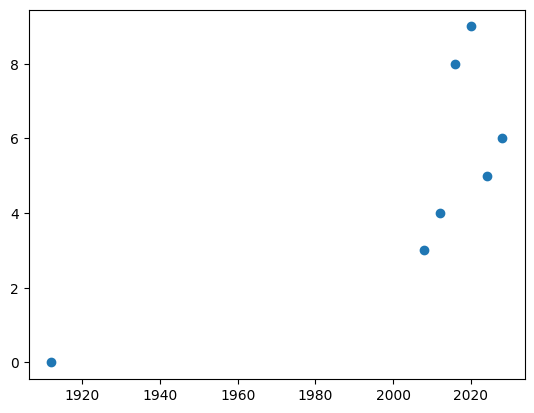

In [227]:
display(sim_data[sim_data['NOC'] == 'Serbia'].loc[:, ['Year', 'Gold', 'Silver', 'Bronze', 'Total', 'Is_Host', 'Ex-Host', 'Host Continent', 'Team Size', 'Possible Bronze', 'Possible Silver', 'Possible Bronze']])
plt.scatter(sim_data[sim_data['NOC'] == 'Serbia']['Year'], sim_data[sim_data['NOC'] == 'Serbia']['Total'])

In [22]:
export = sim_data[['Year', 'Country Code', 'Gold', 'Silver', 'Bronze', 'Total', 'Rank']][sim_data['Year'] == 2028].sort_values('Rank', ascending=True).reset_index(drop=True)
display(export)
export.to_csv('data/projected_medals_2028.csv')

,Year,Country Code,Gold,Silver,Bronze,Total,Rank
0,2028,USA,38.0,33.0,30.0,101.0,1.0
1,2028,CHN,30.0,24.0,22.0,76.0,2.0
2,2028,JPN,25.0,24.0,21.0,70.0,3.0
3,2028,AUS,21.0,20.0,18.0,59.0,4.0
4,2028,FRA,20.0,19.0,18.0,57.0,5.0
...,...,...,...,...,...,...,...
201,2028,HAI,0.0,0.0,0.0,0.0,128.5
202,2028,HON,0.0,0.0,0.0,0.0,128.5
203,2028,INA,0.0,0.0,0.0,0.0,128.5
204,2028,GHA,0.0,0.0,0.0,0.0,128.5


In [23]:
most_improved = sim_data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
most_improved = most_improved.sort_values(['Country Code', 'Year'])
most_improved['Difference'] = most_improved.groupby(['Country Code'])['Total'].diff().fillna(0)
most_improved['Cumulative Sum'] = most_improved.groupby(['Country Code'])['Total'].cumsum()
most_improved['Cumulative Sum'] = most_improved.groupby(['Country Code'])['Cumulative Sum'].shift()
most_improved = most_improved.fillna(0)
most_improved['% Difference'] = most_improved['Difference'] / most_improved['Cumulative Sum']

most_improved_raw = most_improved.sort_values(by='Difference', ascending=False).loc[most_improved['Year'] == 2028].reset_index(drop=True)
most_improved_pct = most_improved.sort_values(by='% Difference', ascending=False).loc[most_improved['Year'] == 2028].reset_index(drop=True)

# most_improved.loc[row]

In [24]:
display(most_improved_pct)

,Rank,NOC,Gold,Silver,Bronze,Total,Year,Country Code,Is_Host,Ex-Host,...,Silver - 1,Bronze - 1,Team Size - 1,Gold - 2,Silver - 2,Bronze - 2,Team Size - 2,Difference,Cumulative Sum,% Difference
0,23.5,Serbia,3.0,3.0,3.0,9.0,2028,SRB,0,0,...,1.0,1.0,135.0,3.0,1.0,5.0,135.0,4.0,29.0,0.137931
1,27.0,Egypt,2.0,3.0,3.0,8.0,2028,EGY,0,0,...,1.0,1.0,207.0,1.0,1.0,4.0,207.0,5.0,39.0,0.128205
2,42.0,Nigeria,1.0,1.0,1.0,3.0,2028,NGR,0,0,...,0.0,0.0,103.0,0.0,1.0,1.0,103.0,3.0,27.0,0.111111
3,18.0,Argentina,3.0,4.0,4.0,11.0,2028,ARG,0,0,...,1.0,1.0,154.0,0.0,1.0,2.0,154.0,8.0,80.0,0.100000
4,11.0,Spain,11.0,12.0,11.0,34.0,2028,ESP,0,1,...,4.0,9.0,526.0,3.0,8.0,6.0,526.0,16.0,187.0,0.085561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,128.5,Timor-Leste,0.0,0.0,0.0,0.0,2028,TLS,0,0,...,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,NaN
202,128.5,Tuvalu,0.0,0.0,0.0,0.0,2028,TUV,0,0,...,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN
203,128.5,Vanuatu,0.0,0.0,0.0,0.0,2028,VAN,0,0,...,0.0,0.0,6.0,0.0,0.0,0.0,6.0,0.0,0.0,NaN
204,128.5,Saint Vincent and the Grenadines,0.0,0.0,0.0,0.0,2028,VIN,0,0,...,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,NaN


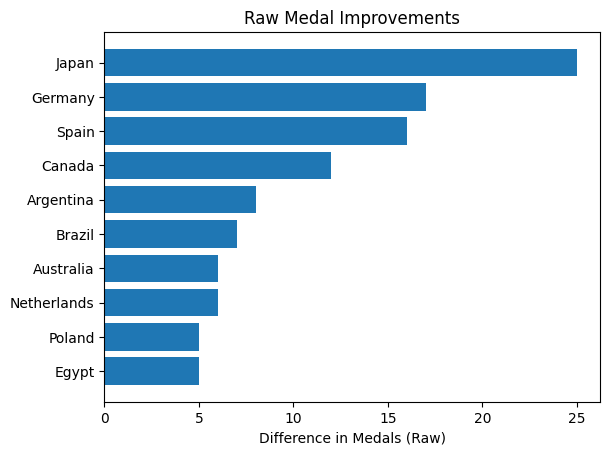

In [25]:
fig, ax = plt.subplots()

ax.barh(most_improved_raw.loc[:9, 'NOC'], most_improved_raw.loc[:9, 'Difference'], align='center')
ax.set_yticks(most_improved_raw.index.values[:10], labels=most_improved_raw.loc[:9, 'NOC'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Difference in Medals (Raw)')
ax.set_title('Raw Medal Improvements')

plt.show()

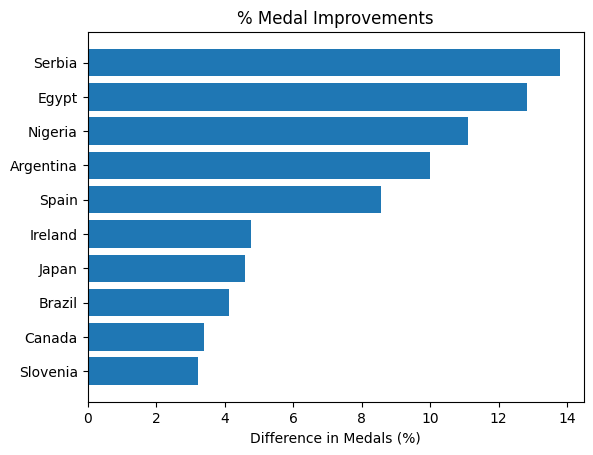

In [26]:
fig, ax = plt.subplots()

ax.barh(most_improved_pct.loc[:9, 'NOC'], most_improved_pct.loc[:9, '% Difference'] * 100, align='center')
ax.set_yticks(most_improved_pct.index.values[:10], labels=most_improved_pct.loc[:9, 'NOC'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Difference in Medals (%)')
ax.set_title('% Medal Improvements')

plt.show()

In [31]:
import statsmodels.api as sm
from statsmodels.multivariate.multivariate_ols import MultivariateLS

In [37]:
train = train.rename(columns={
    'Gold - 1': 'Gold_1',
    'Gold - 2': 'Gold_2',
    'Silver - 1': 'Silver_1',
    'Silver - 2': 'Silver_2',
    'Bronze - 1': 'Bronze_1',
    'Bronze - 2': 'Bronze_2',
    'Ex-Host': 'Ex_Host',
    'Team Size': 'Team_Size',
    'Participated Events': 'Participated_Events',
    '% Female': 'Pct_Female',
})
train

,Gold_1,Gold_2,Silver_1,Silver_2,Bronze_1,Bronze_2,Ex_Host,Team_Size,Participated_Events,Pct_Female,Year,Possible Gold,Possible Silver,Possible Bronze,Gold,Silver,Bronze
0,0.0,0.0,0.0,0.0,0.0,0.0,0,16.0,4,0.000000,1936,129.0,129.0,129.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0,25.0,2,0.000000,1948,136.0,136.0,136.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0,12.0,1,0.000000,1956,151.0,151.0,151.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0,16.0,13,0.000000,1960,150.0,150.0,150.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0,8.0,8,0.000000,1964,163.0,163.0,163.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3402,1.0,0.0,1.0,0.0,1.0,0.0,0,16.0,15,0.384615,2008,302.0,302.0,302.0,1.0,3.0,0.0
3403,1.0,1.0,3.0,1.0,0.0,1.0,0,9.0,8,0.428571,2012,302.0,302.0,302.0,0.0,0.0,0.0
3404,0.0,1.0,0.0,3.0,0.0,0.0,0,31.0,13,0.700000,2016,306.0,306.0,306.0,0.0,0.0,0.0
3405,0.0,0.0,0.0,0.0,0.0,0.0,0,5.0,5,0.200000,2020,339.0,339.0,339.0,0.0,0.0,0.0


In [41]:
mod = MultivariateLS.from_formula('Gold + Silver + Bronze ~ Gold_1 + Gold_2 + Silver_1 + Silver_2 + Bronze_1 + Bronze_2 + Ex_Host + Team_Size + Participated_Events + Pct_Female', data=train)
res = mod.fit()

In [42]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           MultivariateLS Regression Results                            
========================================================================================
Dep. Variable:     ['Gold', 'Silver', 'Bronze']   No. Observations:                 3202
Model:                           MultivariateLS   Df Residuals:                     3191
Method:                           Least Squares   Df Model:                           30
Date:                          Sun, 26 Jan 2025                                         
Time:                                  22:44:54                                         
=======================================================================================
               Gold       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.2660      0.083     -3.221      0.001      -0.428      -0.104
Gold_1                  0.4392      0.026     16.765      0.000       0.388       0.491
Gold_2                  0.3292      0.027     12.124      0.000       0.276       0.382
Silver_1                0.0440      0.033      1.334      0.182      -0.021       0.109
Silver_2               -0.0432      0.035     -1.248      0.212      -0.111       0.025
Bronze_1               -0.1117      0.030     -3.772      0.000      -0.170      -0.054
Bronze_2               -0.0801      0.031     -2.589      0.010      -0.141      -0.019
Ex_Host                -1.1832      0.157     -7.537      0.000      -1.491      -0.875
Team_Size               0.0389      0.001     31.093      0.000       0.036       0.041
Participated_Events    -0.0548      0.003    -16.095      0.000      -0.061      -0.048
Pct_Female              0.7999      0.241      3.313      0.001       0.326       1.273
---------------------------------------------------------------------------------------
             Silver       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.1967      0.067     -2.951      0.003      -0.327      -0.066
Gold_1                  0.1976      0.021      9.348      0.000       0.156       0.239
Gold_2                  0.2588      0.022     11.813      0.000       0.216       0.302
Silver_1                0.0423      0.027      1.587      0.113      -0.010       0.094
Silver_2               -0.0595      0.028     -2.133      0.033      -0.114      -0.005
Bronze_1                0.0097      0.024      0.404      0.686      -0.037       0.057
Bronze_2               -0.0272      0.025     -1.091      0.275      -0.076       0.022
Ex_Host                -0.9636      0.127     -7.608      0.000      -1.212      -0.715
Team_Size               0.0409      0.001     40.539      0.000       0.039       0.043
Participated_Events    -0.0555      0.003    -20.212      0.000      -0.061      -0.050
Pct_Female              0.7440      0.195      3.819      0.000       0.362       1.126
---------------------------------------------------------------------------------------
             Bronze       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.2963      0.063     -4.691      0.000      -0.420      -0.172
Gold_1                  0.1719      0.020      8.578      0.000       0.133       0.211
Gold_2                  0.1542      0.021      7.425      0.000       0.113       0.195
Silver_1                0.0175      0.025      0.695      0.487      -0.032       0.067
Silver_2               -0.0021      0.026     -0.079      0.937      -0.054       0.050
Bronze_1                0.0923      0.023      4.074      0.000       0.048       0.137
Bronze_2               -0.0128      0.024     -0.542      0.588      -0.0